# Problem 1. Model inference with graphical model

A graphical model provides a visual overview of inderdepedency structures of random variables to compactly represent their joint distribution.

In this problem, your task is to discover the model of data generating process for the following graphical model. Before proceeding, see "Graphical model" part of "Going Bayesian" section notebook for review of notations.

In [1]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import daft

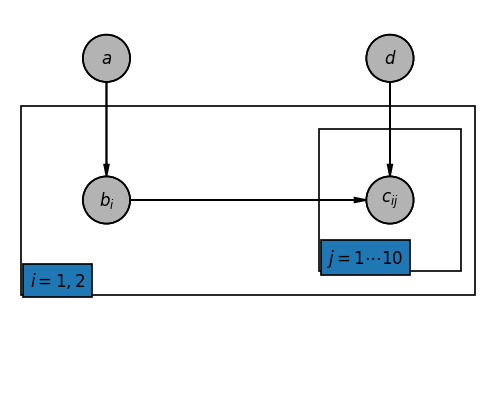

In [2]:
pgm = daft.PGM(shape=(5,4))

# Add nodes
pgm.add_node(daft.Node("a", r"$a$", 1, 3.5, observed=True))
pgm.add_node(daft.Node("b_i", r"$b_i$", 1, 2, observed=True))
pgm.add_node(daft.Node("c_ij", r"$c_{ij}$", 4, 2, observed=True))
pgm.add_node(daft.Node("d", r"$d$", 4, 3.5, observed=True))

# Add in the edges
pgm.add_edge("a", "b_i")
pgm.add_edge("b_i", "c_ij")
pgm.add_edge("d", "c_ij")

# Add a plate
pgm.add_plate(daft.Plate([3.25, 1.25, 1.5, 1.5], label=r'$j=1 \cdots 10$'))
pgm.add_plate(daft.Plate([0.1, 1, 4.8, 2], label=r'$i=1, 2$'))


# Render an image
pgm.render()
pgm.figure.dpi = 120

### (a): Write down the factored expression of *joint* distribution specified by this graphical model.

***Your answer here:*** \
P(a,b,c,d) = $\prod_{i=1}^2 \prod_{j=1}^{10}  P(b_i|a) P(c_{i,j}|b_i,d)P(a,d)$

Random variables in this model are drawn from `Normal`, `Exponential`, `Gamma`, and `Beta` distributions, but we are not telling you which random variabble is drawn from which. So, you will have to define `JointDistribution` model with different permutations of distributions, optimize the model parameter via MLE, and choose the model with the largest data likelihood. 

Here is an example to help you get started.

### Neal's funnel

$p(x,y,z)=\mathcal{N}(z|-1.5, 3) \ \mathcal{N}(x|0, \exp(z/4))\ \mathcal{N}(x|0, 1.2\exp(z/4))$


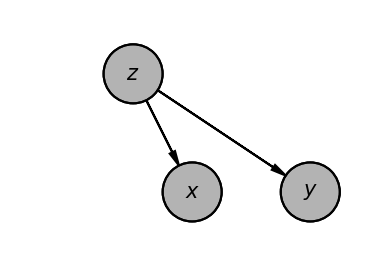

In [3]:
pgm = daft.PGM(shape=(3,2))

# Add nodes
pgm.add_node(daft.Node("z", r"$z$", 1, 1.5, observed=True))
pgm.add_node(daft.Node("x", r"$x$", 1.5, 0.5, observed=True))
pgm.add_node(daft.Node("y", r"$y$", 2.5, 0.5, observed=True))

# Add in the edges
pgm.add_edge("z", "x")
pgm.add_edge("z", "y")

# Render an image
pgm.render()
pgm.figure.dpi = 150

You can specify variable name using `JointDistributionNamed` class.

In [4]:
# Joint distribution of Neal's funnel
joint = tfd.JointDistributionNamed(dict(
    z=          tfd.Normal(loc=-1.5, scale=3.), 
    x=lambda z: tfd.Normal(loc=0., scale=tf.exp(z/4)), 
    y=lambda z: tfd.Normal(loc=0., scale=1.2*tf.exp(z/4)), 
))

joint.sample(1000).keys()

dict_keys(['z', 'y', 'x'])

**Hint**: When defining the dependency of $c$ on $b$, you will obtain two sets of random variable $c$'s (i.e., $c_{1j}$ and $c_{2j}$). You can tell Tensorflow probability to interpret these as a single random varialbe with `Independent` distribution class. Here is an example:

In [5]:
# two independent random variables
rv1 = tfd.Normal(loc=-1., scale=0.1)
rv2 = tfd.Normal(loc=1., scale=0.5)

# single random variable
rv = tfd.Independent(
    distribution=tfd.Normal(loc=[-1., 1], scale=[0.1, 0.5])
)

rv_samples = rv.sample(100)
rv_samples.shape # this will have 2x100 dimension

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


TensorShape([100, 2])

Consider the following graphical model where

$\begin{align*}
  a &\sim \text{Beta}(a|5, 5) \\
  b_i &\sim \text{Exp}(b_i|3) \\
  c_{ij} &\sim \text{LogNormal}(c_{ij}|b_i, a) \\
  \end{align*}$

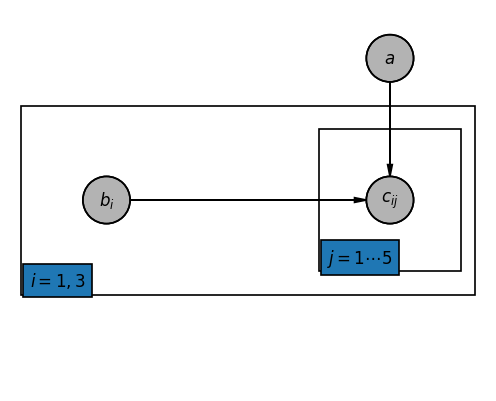

In [6]:
pgm = daft.PGM(shape=(5,4))

# Add nodes
pgm.add_node(daft.Node("b_i", r"$b_i$", 1, 2, observed=True))
pgm.add_node(daft.Node("c_ij", r"$c_{ij}$", 4, 2, observed=True))
pgm.add_node(daft.Node("a", r"$a$", 4, 3.5, observed=True))

# Add in the edges
pgm.add_edge("b_i", "c_ij")
pgm.add_edge("a", "c_ij")

# Add a plate
pgm.add_plate(daft.Plate([3.25, 1.25, 1.5, 1.5], label=r'$j=1 \cdots 5$'))
pgm.add_plate(daft.Plate([0.1, 1, 4.8, 2], label=r'$i=1, 3$'))


# Render an image
pgm.render()
pgm.figure.dpi = 120

Following codes show how we can use `Independent` and `Sample` classes to represent $b_i$ and $c_{ij}$ inside the plates. 

In [7]:
joint = tfd.JointDistributionNamed(dict(
    # a
    a = tfd.Beta(5, 5),

    # we sample b twice using "Sample" 
    b_i = tfd.Sample(
        distribution=tfd.Exponential(3), 
        sample_shape=3,
    ),

    # and use these b's for the mean of LogNormal c
    c_ij = lambda a, b_i: tfd.Sample(
        distribution=tfd.LogNormal(loc=b_i, scale=tf.transpose([a, a, a])),
        sample_shape=5,   
    )
))

samples = joint.sample(100)
for rv_name, rv_sample in samples.items():
  print(rv_name, rv_sample.shape)

b_i (100, 3)
a (100,)
c_ij (100, 3, 5)


Following code seems to be working, but if you try to evaluate `log_prob`...

In [8]:
tf.reduce_mean(joint.log_prob(samples))

InvalidArgumentError: ignored

We see this error because there are three independent sets of $c$'s, and our `joint` doesn't see them as different realizatation of one random variable. We can fix this by making `LogNormal` as `Indendent` distribution as follow.

In [9]:
joint_with_independent_LogNormal = tfd.JointDistributionNamed(dict(
    # a
    a = tfd.Beta(5, 5),

    # we sample b twice using "Sample" 
    b_i = tfd.Sample(
        distribution=tfd.Exponential(3), 
        sample_shape=3,
    ),

    # and use these b's for the mean of LogNormal c
    c_ij = lambda a, b_i: tfd.Independent(
        tfd.Sample(distribution=tfd.LogNormal(loc=b_i, scale=tf.transpose([a, a, a])),
                  sample_shape=5,
        )   
    )
))

tf.reduce_mean(joint_with_independent_LogNormal.log_prob(samples))

<tf.Tensor: shape=(), dtype=float32, numpy=-14.006339>

### (b). Infer this model! 

Once you decide on your model, generate 10,000 samples from your model, [pickle](https://wiki.python.org/moin/UsingPickle) them, and **upload it on Canvas** (We won't use Kaggle this week).

In [20]:
from google.colab import drive
drive.mount('/content/drive')

import os
path = "/content/drive/MyDrive/semester 2/AM216/HW5" # Your path here
os.chdir(path)
dict_samp = np.load("np_samples.pickle", allow_pickle=True)

Mounted at /content/drive


In [25]:
keys = []
vals = []

for key in dict_samp.keys():
  keys.append(key)

for val in dict_samp.values():
  vals.append(val)

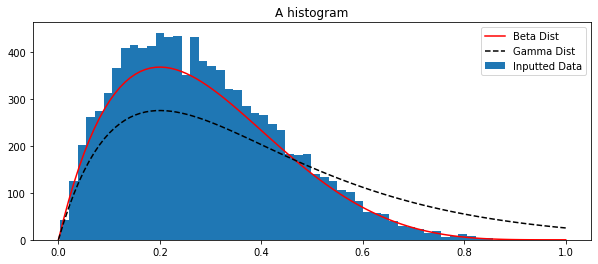

In [61]:
# rv1 = a or 0, rv3 = d or 2
import matplotlib.pyplot as plt
ps = np.linspace(0, 1, 100)
beta_test = tfp.distributions.Beta(2., 5.)
p_beta = beta_test.prob(ps)

gamma_test = tfp.distributions.Gamma(2., 5.)
p_gamma = gamma_test.prob(ps)

plt.figure(figsize=(10,4))
plt.hist(vals[0], bins = 50, label = "Inputted Data")
plt.plot(ps,p_beta*150, "r-", label = "Beta Dist")
plt.plot(ps, p_gamma*150, "k--", label = "Gamma Dist")
plt.title("A histogram")
plt.legend()


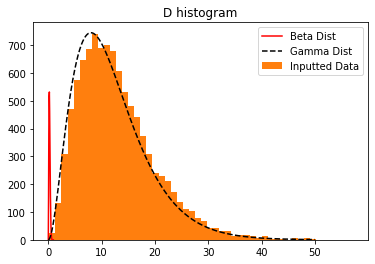

In [111]:
import matplotlib.pyplot as plt
ps = np.linspace(0, 50, 1000)
beta_test = tfp.distributions.Beta(3., 10.)
p_beta = beta_test.prob(ps)

gamma_test = tfd.Gamma(3., 0.25)
p_gamma = gamma_test.prob(ps)

plt.hist(vals[2], bins = 50)
plt.title("D histogram")
plt.hist(vals[2], bins = 50, label = "Inputted Data")
plt.plot(ps,p_beta*150, "r-", label = "Beta Dist")
plt.plot(ps, p_gamma*11000, "k--", label = "Gamma Dist")

plt.legend()


In [112]:

joint = tfd.JointDistributionNamed(dict(
  # a
  a = tfd.Beta(2., 5.),
  d = tfd.Gamma(3., 0.25),

  # we sample b twice using "Sample" 
  b_i = lambda a: tfd.Independent(tfd.Sample( 
      distribution=tfd.LogNormal(loc=a, scale=tf.transpose(a)),
      sample_shape=2,   
  )),

  # and use these b's for the mean of LogNormal c
  c_ij = lambda d, b_i: tfd.Independent(tfd.Sample( 
      distribution=tfd.LogNormal(loc=b_i, scale=tf.transpose([d, d])),
      sample_shape=10,   
  ))
  
))

samples2 = joint.sample(10000)
for rv_name, rv_sample in samples2.items():
  print(rv_name, rv_sample.shape)
print("Reduced mean",tf.reduce_mean(joint.log_prob(samples2)).numpy())

a (10000,)
b_i (10000, 2)
d (10000,)
c_ij (10000, 2, 10)
Reduced mean -inf


In [131]:
joint = tfd.JointDistributionNamed(dict(
  # a
  a = tfd.Beta(2., 5.),
  d = tfd.Beta(2., 8.),

  # we sample b twice using "Sample" 
  b_i = lambda a: tfd.Independent(tfd.Sample( 
      distribution=tfd.LogNormal(loc=a, scale=tf.transpose(a)),
      sample_shape=2,   
  )),

  # and use these b's for the mean of LogNormal c
  c_ij = lambda d, b_i: tfd.Independent(tfd.Sample( 
      distribution=tfd.LogNormal(loc=b_i, scale=tf.transpose([d, d])),
      sample_shape=10,   
  ))
  
))

samples2 = joint.sample(10000)
for rv_name, rv_sample in samples2.items():
  print(rv_name, rv_sample.shape)
print("Reduced mean",tf.reduce_mean(joint.log_prob(samples2)).numpy())

a (10000,)
b_i (10000, 2)
d (10000,)
c_ij (10000, 2, 10)
Reduced mean -19.513805


In [129]:
joint = tfd.JointDistributionNamed(dict(
  # a
  a = tfd.Beta(2., 5.),
  d = tfd.Beta(3., 1),

  # we sample b twice using "Sample" 
  b_i = lambda a: tfd.Independent(tfd.Sample( 
      distribution=tfd.Exponential(a),
      sample_shape=2,   
  )),

  # and use these b's for the mean of LogNormal c
  c_ij = lambda d, b_i: tfd.Independent(tfd.Sample( 
      distribution=tfd.Exponential(d),
      sample_shape=10,   
  ))
  
))

samples2 = joint.sample(10000)
for rv_name, rv_sample in samples2.items():
  print(rv_name, rv_sample.shape)
print("Reduce mean",tf.reduce_mean(joint.log_prob(samples2)).numpy())

a (10000,)
b_i (10000, 2)
d (10000,)
c_ij (10000, 10)
Reduce mean -17.288145


In [120]:
joint = tfd.JointDistributionNamed(dict(
  # a
  a = tfd.Beta(2., 5.),
  d = tfd.Gamma(3., 0.25),

  # we sample b twice using "Sample" 
  b_i = lambda a: tfd.Independent(tfd.Sample( 
      distribution=tfd.Exponential(a),
      sample_shape=2,   
  )),

  # and use these b's for the mean of LogNormal c
  c_ij = lambda d, b_i: tfd.Independent(tfd.Sample( 
      distribution=tfd.Exponential(b_i),
      sample_shape=10,   
  ))
  
))

samples2 = joint.sample(10000)
for rv_name, rv_sample in samples2.items():
  print(rv_name, rv_sample.shape)
print("Reduce mean",tf.reduce_mean(joint.log_prob(samples2)).numpy())

a (10000,)
b_i (10000, 2)
d (10000,)
c_ij (10000, 2, 10)
Reduce mean -10.007871


In [135]:
import pickle
with open('mysamples.pickle', 'wb') as f:
    pickle.dump(samples2, f)

In [136]:
keys, vals = zip(*samples2.items())